In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
# Evaluation

## model import
model_filepath = "data/models/2020-10-17.h5" # learned by confidence map labels
model = tf.keras.models.load_model(model_filepath)

## hyper params
thresholds = 0.3

## test_ds import
element_spec = {
    "image": tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
    "label": tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
    }
test_ds = tf.data.experimental.load("data/datasets/test_ds", element_spec)

In [10]:
# prediction
for batch in test_ds:
    images = batch['image']
    labels = batch['label']

preds = model.predict(test_ds) > thresholds


In [20]:
center_x, center_y = (64, 64)
fai_dash = np.pi
theta_ratio = 0.5 * np.pi / 64.0

def get_line_idxs(label):
    x, y =  np.where(label)
    return y, x

def get_fai(y, x):
    return np.arctan2(x, y)

def get_distance(y, x, h):
    r = np.sqrt(np.square(x) + np.square(y))
    theta = np.round(r * theta_ratio)
    return np.tan(theta) * h

def get_points(label, h):
    ys, xs = get_line_idxs(label)
    fais = []
    distances = []
    anomalies_x = []
    anomalies_y = []
    for y, x in zip(ys, xs):
        x, y = x - center_x, y - center_y
        distance = get_distance(x, y, h)
        if distance > 10.0:
            continue
        if distance < 0:
            anomalies_x.append(x + center_x)
            anomalies_y.append(y + center_y)

        fai = get_fai(x, y) - fai_dash

        distances.append(distance)
        fais.append(fai)
    return np.array(fais), np.array(distances), anomalies_x, anomalies_y

In [21]:
get_distance(48 - 64, 96 - 64, 1.6)

2.4918523594478437

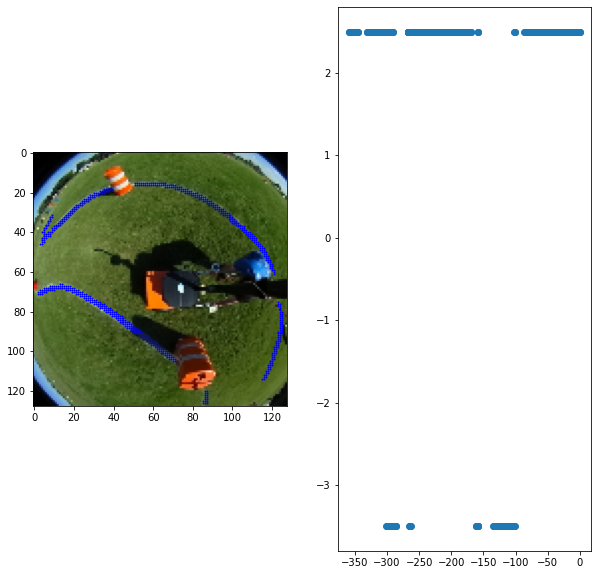

In [22]:
h = 1.6
image = images[0]
label = preds[0].reshape((128, 128))
fais, distances, x, y = get_points(label, h)
_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].scatter(*get_line_idxs(label), c='blue', s=1)
# ax[0].imshow(label, cmap='gray')
ax[1].scatter(np.array(fais) * 180 / np.pi, distances)